# Image Classification Model Training using TensorFlow by Anurug Upascha
## Dog vs Cat Classification with Keras Applications

### 1. Import Libraries
```python
import matplotlib.pyplot as plt
...
```
Cell นี้ทำการ import libraries ที่จำเป็นสำหรับการสร้างและฝึกโมเดล เช่น TensorFlow, Keras, NumPy และ libraries สำหรับการแสดงผล

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import *
import seaborn as sns
import PIL
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, TensorBoard, CSVLogger
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.applications import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *
import os
print("tf Version = ",tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU'))) #if use WSL2

tf Version =  2.20.0
Num GPUs Available:  0


### 2. Configuration Setup
```python
batch_size = 24
...
```
Cell นี้กำหนดค่า parameters พื้นฐานสำหรับการฝึกโมเดล:
- ขนาด batch size
- ขนาดของรูปภาพ input
- ตำแหน่งของ dataset

In [3]:
batch_size = 24
img_height = 224
img_width = 224
data_dir = 'datasets/dogcat/'

### 3.1 Load Training Dataset
```python
train_ds = tf.keras.utils.image_dataset_from_directory(
...
```
Cell นี้โหลดข้อมูลสำหรับการฝึกฝน (training set) โดยแบ่ง 70% ของข้อมูลทั้งหมด

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,  # First split: 70% training, 30% for val+test
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2003 files belonging to 2 classes.
Using 1403 files for training.


### 3.2 Load Validation and Test Datasets
```python
remaining_ds = tf.keras.utils.image_dataset_from_directory(
...
```
Cell นี้โหลดข้อมูลส่วนที่เหลือ 30% เพื่อนำไปแบ่งเป็น validation และ test sets

In [5]:
remaining_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.3,  # Taking the remaining 30%
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2003 files belonging to 2 classes.
Using 600 files for validation.


### 3.3 Split Validation and Test Sets
```python
val_batches = tf.data.experimental.cardinality(remaining_ds) // 2
...
```
Cell นี้แบ่งข้อมูลที่เหลือออกเป็น validation set และ test set อย่างละครึ่ง

```python
val_ds = remaining_ds.take(val_batches)
test_ds = remaining_ds.skip(val_batches)
```


*   take(val_batches) คือการนำข้อมูล n batch แรกจาก remaining_ds มาเป็น validation set
*   ถ้า val_batches = 10 จะเป็นการนำ 10 batch แรกมาเป็น validation set
*   skip(val_batches) คือการข้ามข้อมูล n batch แรก แล้วนำข้อมูลที่เหลือมาเป็น test set
*   ถ้า val_batches = 10 จะเป็นการข้าม 10 batch แรก แล้วนำข้อมูลที่เหลือมาเป็น test set


In [6]:
val_batches = tf.data.experimental.cardinality(remaining_ds) // 2
test_batches = val_batches

In [7]:
val_ds = remaining_ds.take(val_batches)
test_ds = remaining_ds.skip(val_batches)

### 3.4 Get Class Information
```python
class_names = train_ds.class_names
...
```
Cell นี้แสดงข้อมูลของ classes ที่ใช้ในการจำแนก (dog และ cat) และจำนวน classes

In [9]:
class_names = train_ds.class_names
num_classes = len(class_names)
print('classname: ',class_names)
print('class: ',num_classes)

classname:  ['cats', 'dogs']
class:  2


### 4. Visualize Sample Images
```python
plt.figure(figsize=(10, 10))
...
```
Cell นี้แสดงตัวอย่างรูปภาพจาก training set พร้อมกับ labels

(24, 224, 224, 3)
(24,)


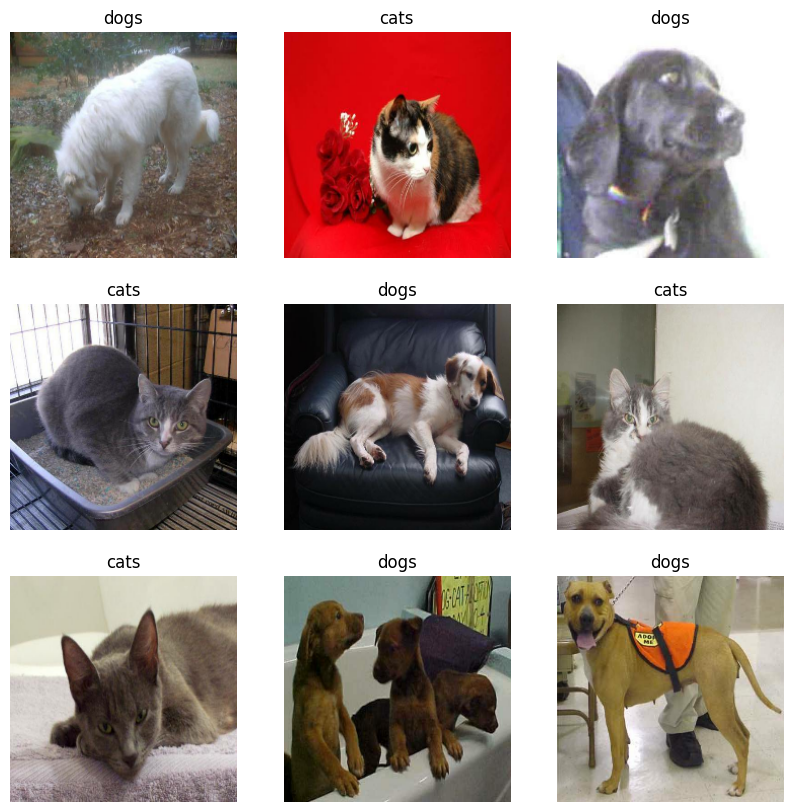

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

### 5. Optimize Dataset Performance
```python
AUTOTUNE = tf.data.AUTOTUNE
...
```
Cell นี้ปรับแต่ง dataset pipeline เพื่อเพิ่มประสิทธิภาพในการฝึกโมเดล


In [11]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


### 6. Normalize Image Data
```python
normalization_layer = layers.Rescaling(1./224)
...
```
Cell นี้ทำการ normalize ข้อมูลรูปภาพให้อยู่ในช่วง [0,1]

#### การ Normalize ข้อมูลรูปภาพ

การ normalize ข้อมูลรูปภาพเป็นขั้นตอนสำคัญในการเตรียมข้อมูลก่อนป้อนเข้าสู่โมเดล deep learning โดยเป็นการปรับค่าพิกเซลให้อยู่ในช่วง [0,1]

#### รูปแบบการเก็บค่าพิกเซลในรูปภาพ

รูปภาพดิจิตอลปกติจะเก็บค่าแต่ละพิกเซลในช่วง 0-255 โดย:
* 0 = สีดำ
* 255 = สีขาว
* ค่าระหว่าง 0-255 = เฉดสีต่างๆ

#### เหตุผลที่ต้อง Normalize

โมเดล deep learning มักทำงานได้ดีกับข้อมูลที่มีขนาดเล็ก การใช้ค่าพิกเซล 0-255 โดยตรงอาจก่อให้เกิดปัญหา:
* การคำนวณใช้เวลานาน
* การเรียนรู้ของโมเดลไม่เสถียร
* เกิดปัญหา gradient explosion

#### วิธีการ Normalize

```python
# สร้าง normalization layer
normalization_layer = layers.Rescaling(1./224)

# ใช้ normalize ข้อมูล
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
```

#### ตัวอย่างการแปลงค่า

| ค่าพิกเซลเดิม | การคำนวณ | ค่าหลัง Normalize |
|-------------|----------|------------------|
| 0 | 0/224 | 0.0 |
| 128 | 128/224 | 0.57 |
| 255 | 255/224 | 1.0 |

#### การตรวจสอบผลลัพธ์

```python
# ตรวจสอบค่าต่ำสุดและสูงสุดหลัง normalize
print(np.min(first_image), np.max(first_image))
```

#### ประโยชน์ของการ Normalize

1. โมเดลเรียนรู้ได้ดีขึ้น
2. ลดปัญหา vanishing/exploding gradients
3. เพิ่มความเร็วในการเทรนโมเดล
4. เปรียบเทียบระหว่างรูปภาพได้ง่ายขึ้น

#### ข้อควรระวัง

1. ต้อง normalize ทุกชุดข้อมูลด้วยวิธีเดียวกัน:
   * Training set
   * Validation set
   * Test set
2. เก็บค่าที่ใช้ normalize (scaling factor) ไว้สำหรับข้อมูลใหม่
3. ตรวจสอบค่าหลัง normalize ว่าอยู่ในช่วง [0,1] จริง

## Note

การ normalize เป็นเพียงขั้นตอนหนึ่งในการ preprocess ข้อมูล อาจต้องใช้ร่วมกับเทคนิคอื่นๆ เช่น:
* Data augmentation
* Standardization
* Feature scaling

เพื่อให้ได้ผลลัพธ์ที่ดีที่สุดในการฝึกโมเดล


In [12]:
normalization_layer = layers.Rescaling(1./224)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))


### 7. Verify Normalization
```python
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
...
```
Cell นี้ตรวจสอบว่าการ normalize ทำงานถูกต้อง

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

6.2580893e-06 0.0050821113


### 8. Create Model Architecture
```python
num_classes = len(class_names)
...
```
Cell นี้สร้างโครงสร้างโมเดลโดยใช้ Keras Applications และเพิ่ม custom layers

#### Available Models

| Model                | Size (MB) | Top-1 Accuracy | Top-5 Accuracy | Parameters | Depth | CPU Time (ms) | GPU Time (ms) |
|----------------------|----------|---------------|---------------|------------|-------|--------------|--------------|
| Xception            | 88       | 79.0%         | 94.5%         | 22.9M      | 81    | 109.4        | 8.1          |
| VGG16               | 528      | 71.3%         | 90.1%         | 138.4M     | 16    | 69.5         | 4.2          |
| VGG19               | 549      | 71.3%         | 90.0%         | 143.7M     | 19    | 84.8         | 4.4          |
| ResNet50            | 98       | 74.9%         | 92.1%         | 25.6M      | 107   | 58.2         | 4.6          |
| ResNet50V2         | 98       | 76.0%         | 93.0%         | 25.6M      | 103   | 45.6         | 4.4          |
| ResNet101          | 171      | 76.4%         | 92.8%         | 44.7M      | 209   | 89.6         | 5.2          |
| ResNet101V2        | 171      | 77.2%         | 93.8%         | 44.7M      | 205   | 72.7         | 5.4          |
| ResNet152          | 232      | 76.6%         | 93.1%         | 60.4M      | 311   | 127.4        | 6.5          |
| ResNet152V2        | 232      | 78.0%         | 94.2%         | 60.4M      | 307   | 107.5        | 6.6          |
| InceptionV3        | 92       | 77.9%         | 93.7%         | 23.9M      | 189   | 42.2         | 6.9          |
| InceptionResNetV2  | 215      | 80.3%         | 95.3%         | 55.9M      | 449   | 130.2        | 10.0         |
| MobileNet          | 16       | 70.4%         | 89.5%         | 4.3M       | 55    | 22.6         | 3.4          |
| MobileNetV2        | 14       | 71.3%         | 90.1%         | 3.5M       | 105   | 25.9         | 3.8          |
| DenseNet121        | 33       | 75.0%         | 92.3%         | 8.1M       | 242   | 77.1         | 5.4          |
| DenseNet169        | 57       | 76.2%         | 93.2%         | 14.3M      | 338   | 96.4         | 6.3          |
| DenseNet201        | 80       | 77.3%         | 93.6%         | 20.2M      | 402   | 127.2        | 6.7          |
| NASNetMobile       | 23       | 74.4%         | 91.9%         | 5.3M       | 389   | 27.0         | 6.7          |
| NASNetLarge        | 343      | 82.5%         | 96.0%         | 88.9M      | 533   | 344.5        | 20.0         |
| EfficientNetB0     | 29       | 77.1%         | 93.3%         | 5.3M       | 132   | 46.0         | 4.9          |
| EfficientNetB1     | 31       | 79.1%         | 94.4%         | 7.9M       | 186   | 60.2         | 5.6          |
| EfficientNetB2     | 36       | 80.1%         | 94.9%         | 9.2M       | 186   | 80.8         | 6.5          |
| EfficientNetB3     | 48       | 81.6%         | 95.7%         | 12.3M      | 210   | 140.0        | 8.8          |
| EfficientNetB4     | 75       | 82.9%         | 96.4%         | 19.5M      | 258   | 308.3        | 15.1         |
| EfficientNetB5     | 118      | 83.6%         | 96.7%         | 30.6M      | 312   | 579.2        | 25.3         |
| EfficientNetB6     | 166      | 84.0%         | 96.8%         | 43.3M      | 360   | 958.1        | 40.4         |
| EfficientNetB7     | 256      | 84.3%         | 97.0%         | 66.7M      | 438   | 1578.9       | 61.6         |
| ConvNeXtTiny      | 109.42   | 81.3%         | -             | 28.6M      | -     | -            | -            |
| ConvNeXtSmall     | 192.29   | 82.3%         | -             | 50.2M      | -     | -            | -            |
| ConvNeXtBase      | 338.58   | 85.3%         | -             | 88.5M      | -     | -            | -            |
| ConvNeXtLarge     | 755.07   | 86.3%         | -             | 197.7M     | -     | -            | -            |
| ConvNeXtXLarge    | 1310     | 86.7%         | -             | 350.1M     | -     | -            | -            |



In [13]:
# จำนวนคลาสในงานจำแนกประเภท
num_classes = len(class_names)

# สร้าง input layer สำหรับรูปภาพขนาด (img_height, img_width, 3)
inputs = Input(shape=(img_height, img_width, 3))

# สร้าง base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=inputs)
base_model.trainable = True

# Freeze early layers, unfreeze later layers
for layer in base_model.layers[:-4]:
    layer.trainable = False

x = base_model.output

# เพิ่ม custom layers
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = GlobalAveragePooling2D()(x)  # สำคัญมาก - แปลง 4D เป็น 2D
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
outputs = Dense(num_classes, activation='softmax')(x)

# สร้างโมเดลโดยกำหนด inputs และ outputs
model = Model(inputs=base_model.input, outputs=outputs)


# คอมไพล์โมเดล
model.compile(
    optimizer=AdamW(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# ตรวจสอบโครงสร้าง
print("Model output shape:", model.output_shape)
model.summary()

/tmp/ipykernel_7990/2139832162.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 32)       │       368,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,639,394 (10.07 MB)

 Trainable params: 381,346 (1.45 MB)

 Non-trainable params: 2,258,048 (8.61 MB)

### 9. Train Model
```python
model_save_path = 'models/EfficientNetB0_dogcat_10.keras'
...
```
Cell นี้ทำการฝึกโมเดลพร้อมกับบันทึกโมเดลที่ดีที่สุด

In [14]:
model_save_path = 'models/VGG16_100Epochs.keras'

epochs = 10
checkpoint = ModelCheckpoint(
    filepath=model_save_path,  # ตำแหน่งไฟล์
    monitor='val_loss',       # เมตริกที่ใช้ในการตรวจสอบ (เช่น val_loss หรือ val_accuracy)
    save_best_only=True,      # บันทึกเฉพาะโมเดลที่ดีที่สุด
    save_weights_only=False,  # บันทึกทั้งโมเดล (ไม่ใช่แค่ weights)
    mode='min',               # เลือกโมเดลที่มีค่าต่ำสุดสำหรับ val_loss
    verbose=1,                 # แสดงข้อความเมื่อบันทึก
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks = [
    checkpoint,
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]
)

Epoch 1/100


I0000 00:00:1739369518.786683    8068 service.cc:148] XLA service 0x7f6fc00040d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739369518.788949    8068 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-02-12 21:11:58.998937: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1739369520.209249    8068 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-02-12 21:12:05.581094: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,32,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1280,7,7]{3,2,1,0}, f32[32,1280,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_con

 2/44 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.4766 - loss: 0.7108  

I0000 00:00:1739369530.225787    8068 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 5/44 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - accuracy: 0.5949 - loss: 0.6027

2025-02-12 21:12:15.639954: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[27,32,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[27,1280,7,7]{3,2,1,0}, f32[32,1280,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.8685 - loss: 0.2899 

2025-02-12 21:12:25.528206: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[32,32,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1280,7,7]{3,2,1,0}, f32[32,1280,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}



Epoch 1: val_loss improved from inf to 0.17673, saving model to models/MobileNetV2_DogCat_100Epochs.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 434ms/step - accuracy: 0.8702 - loss: 0.2869 - val_accuracy: 0.9583 - val_loss: 0.1767
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9869 - loss: 0.0405
Epoch 2: val_loss improved from 0.17673 to 0.08151, saving model to models/MobileNetV2_DogCat_100Epochs.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.9869 - loss: 0.0404 - val_accuracy: 0.9653 - val_loss: 0.0815
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.9974 - loss: 0.0131
Epoch 3: val_loss improved from 0.08151 to 0.01332, saving model to models/MobileNetV2_DogCat_100Epochs.keras
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9974 - loss: 0.0130 - val_accuracy: 0.9931 - val_loss: 0.0133
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9969 - loss: 0.0078
Epoch 4: val_loss did not improve from 0.01332
44/44 ━━━━━━━━━━━━

### 10. Evaluate Model
```python
test_loss, test_accuracy = model.evaluate(test_ds)
...
```
Cell นี้ประเมินประสิทธิภาพของโมเดลบน test set

In [15]:
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"\nTest accuracy: {test_accuracy:.4f}")

 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9842 - loss: 0.0910     

2025-02-12 21:45:50.384958: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=0} for conv (f32[24,32,7,7]{3,2,1,0}, u8[0]{0}) custom-call(f32[24,1280,7,7]{3,2,1,0}, f32[32,1280,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}


10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 811ms/step - accuracy: 0.9824 - loss: 0.1173

Test accuracy: 0.9744


### 11. Plot Training History
```python
acc = history.history['accuracy']
...
```
Cell นี้แสดงกราฟของ accuracy และ loss ระหว่างการฝึกโมเดล

### 12. Create Confusion Matrix
```python
y_pred = model.predict(test_ds)
...
```
Cell นี้สร้าง confusion matrix เพื่อแสดงผลการทำนายของโมเดล

### 13. Generate Performance Curves
```python
y_pred = model.predict(test_ds)
...
```
Cell นี้สร้าง Precision-Recall curve และ F1 curve เพื่อแสดงประสิทธิภาพของโมเดลในรูปแบบต่างๆ

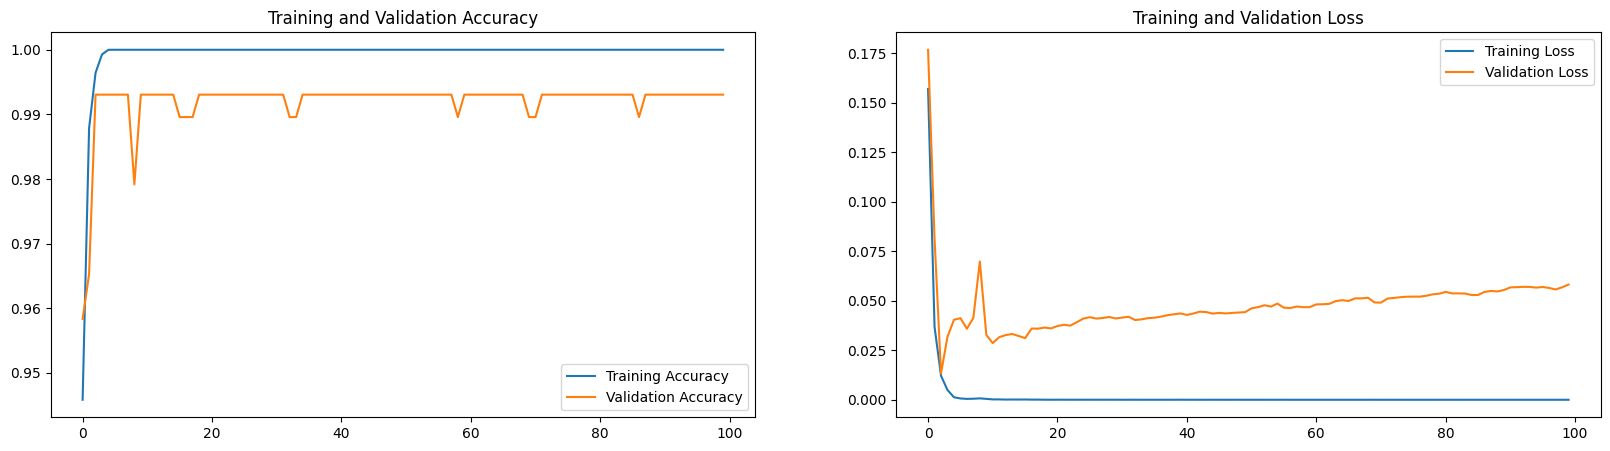

In [16]:
os.makedirs('validpic', exist_ok=True)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('validpic/training_vs_validation.png')
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 625ms/step


2025-02-12 21:46:18.183976: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


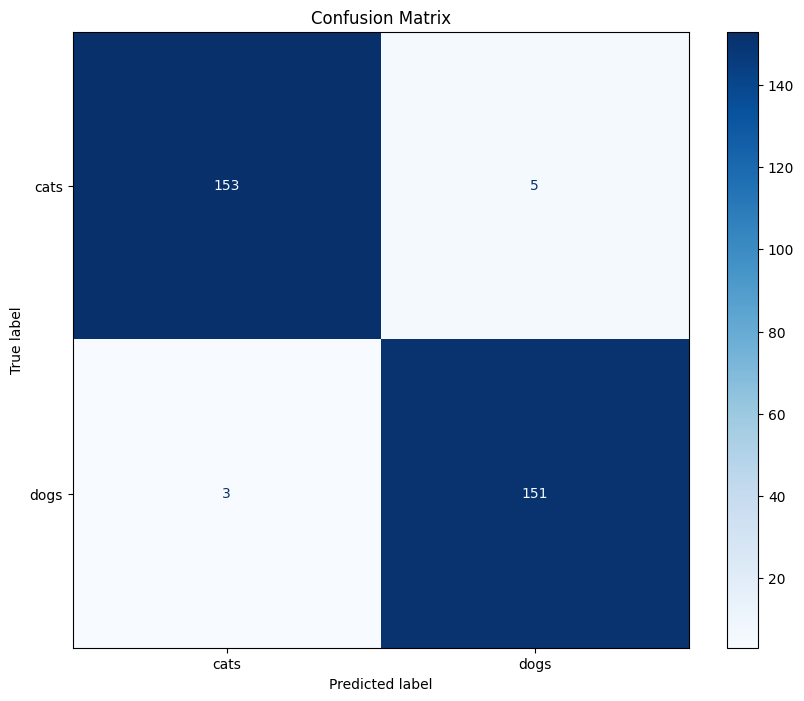

In [17]:
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = []
for _, labels in test_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=ax, cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.savefig('validpic/confusion_matrix.png')
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step 


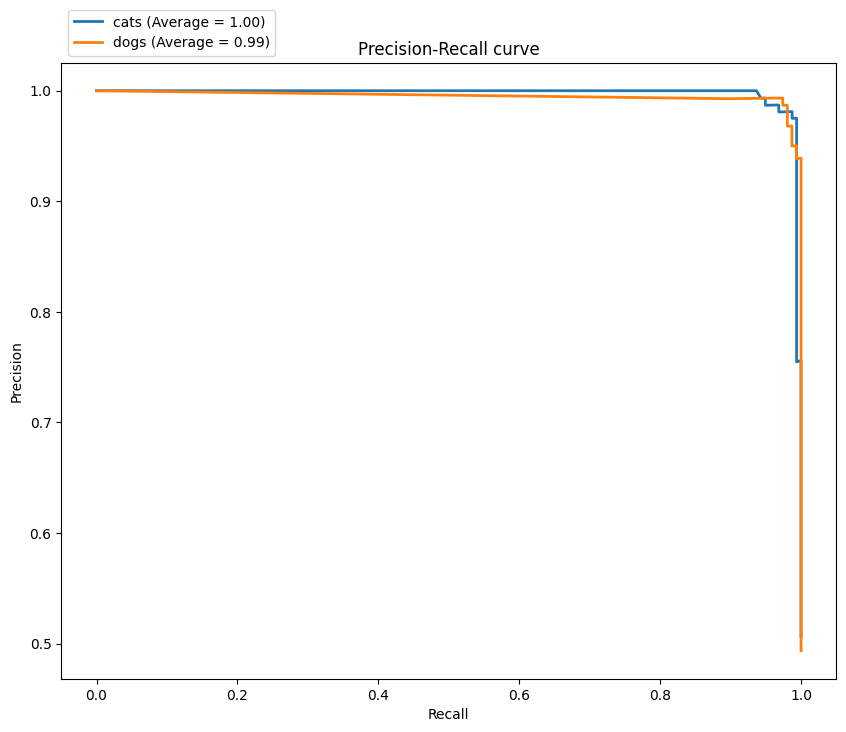

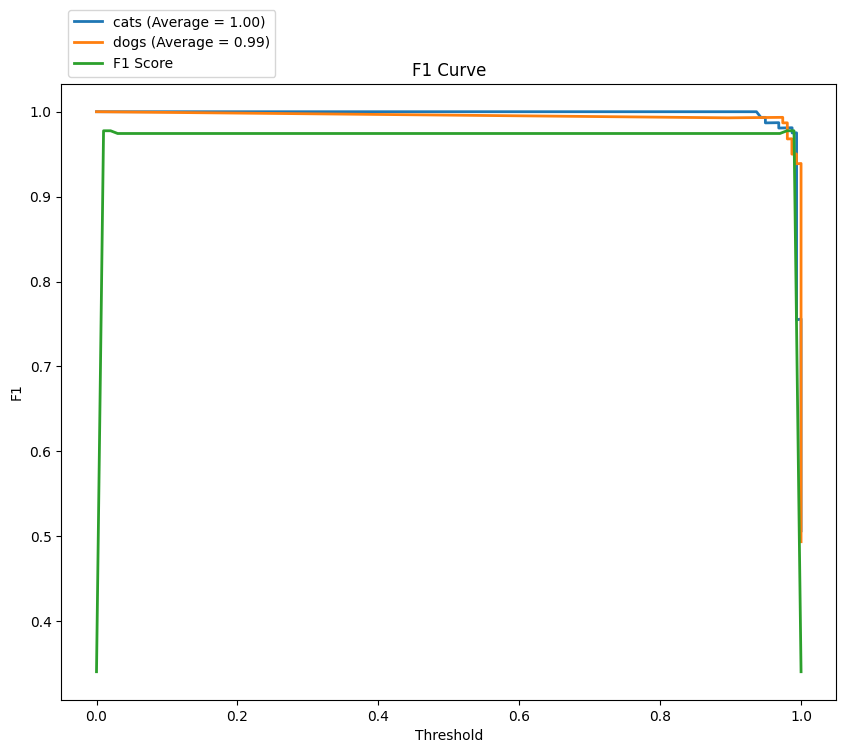

In [18]:
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)


y_true = []
for _, labels in test_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)


precision = dict()
recall = dict()
average_precision = dict()
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_true == i, y_pred[:, i])
    average_precision[i] = average_precision_score(y_true == i, y_pred[:, i])


plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'{class_names[i]} (Average = {average_precision[i]:.2f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve")
plt.legend(loc='lower left', bbox_to_anchor=(0, 1))
plt.savefig('validpic/precision_recall_curve.png')
plt.show()


y_pred_proba = np.max(y_pred, axis=1)           # ค่าความมั่นใจสูงสุด
y_pred_label = np.argmax(y_pred, axis=1)        # class ที่ predict

f1 = []
for t in thresholds:
    y_pred_thresh = [
        y_pred_label[i] if y_pred_proba[i] >= t else -1  # -1 = ทิ้ง sample นี้
        for i in range(len(y_true))
    ]
    # filter ทิ้ง -1 ก่อนคำนวณ F1
    valid_idx = [i for i, v in enumerate(y_pred_thresh) if v != -1]
    f1_t = f1_score(y_true[valid_idx], np.array(y_pred_thresh)[valid_idx], average="weighted")
    f1.append(f1_t)

# plt.axhline(f1[0], color='red', linestyle='--', label=f'Baseline F1 (t=0): {f1[0]:.2f}')
plt.figure(figsize=(10, 8))
plt.plot(thresholds, f1, lw=2, label="F1 Score (weighted)")
plt.xlabel("Threshold")
plt.ylabel("F1")
plt.title("F1 Curve")
plt.legend()
plt.savefig('validpic/f1_curve.png')
plt.show()
